# 0.0 Imports

In [338]:
import math
import numpy  as np
import pandas as pd
import random
import pickle
import requests
import warnings
import inflection
import seaborn as sns
import xgboost as xgb

from scipy                 import stats  as ss
from boruta                import BorutaPy
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML


from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

warnings.filterwarnings( 'ignore' )

# 0.1 helper functions

In [339]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )
     
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )

    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).as_matrix()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

0.2 Loading Data

In [340]:
df_sales_raw = pd.read_csv('/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/data/train-2.csv', low_memory=False)
df_store_raw = pd.read_csv('/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [341]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
179555,41,5,2015-02-20,6029,482,1,1,0,1,d,c,1180.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


## Descrição dos dados:

In [342]:
df_raw.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [343]:
df1 = df_raw.copy()

In [344]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [345]:
 cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore(x)

cols_new =list(map(snakecase, cols_old))
# rename
df1.columns = cols_new

In [346]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

1.2 Data Dimensions

In [347]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of column: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of column: 18


1.3 Data Types

In [348]:

# temos que alterar o tipo da coluna date, pois o python entende como object para fazer isso vamos utilizar 
# o metodo do pandas to_datetime()
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

In [349]:
# coluna_removida = df1.pop('dates')

## 1.4 Check NA

In [350]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [351]:
#competition_distance        
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#promo_interval              
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [352]:
df1.sample(5).T

,927128,931703,648123,940978,498943
store,234,349,1094,704,209
day_of_week,5,1,4,7,4
date,2013-03-22 00:00:00,2013-03-18 00:00:00,2013-11-28 00:00:00,2013-03-10 00:00:00,2014-04-10 00:00:00
sales,11815,0,3110,0,5624
customers,1077,0,267,0,646
open,1,0,1,0,1
promo,1,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,c,d,d,a


In [353]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

1.1

1.1

In [354]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [355]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

In [356]:
df1.sample().T

,758788
store,259
day_of_week,2
date,2013-08-20 00:00:00
sales,8893
customers,2140
open,1
promo,0
state_holiday,0
school_holiday,0
store_type,b


## 1.7 Descriptive Statistical

In [357]:
num_attributes = df1.select_dtypes( include=["int64", "float64"])
cat_attributes = df1.select_dtypes( exclude=["int64", "float64", "datetime64[ns]"])

In [358]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
503026,0,a,a,"Jan,Apr,Jul,Oct",Apr
481638,0,a,a,"Jan,Apr,Jul,Oct",Apr


## 1.7.1 numerical attributes

In [359]:
# central tendency mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min() )).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns= ["attributes", "min", "max", "range", "mean", "median", "std", "skew", "kurtosis"]
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='competition_distance', ylabel='Density'>

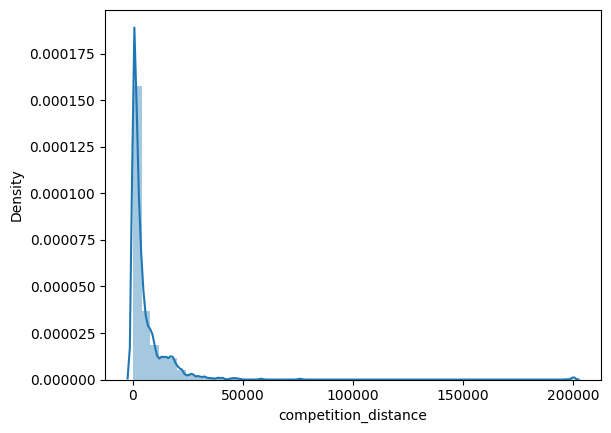

In [360]:
sns.distplot(df1["competition_distance"])

## 1.7.2 Categorical Attributres

In [361]:
cat_attributes.apply (lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

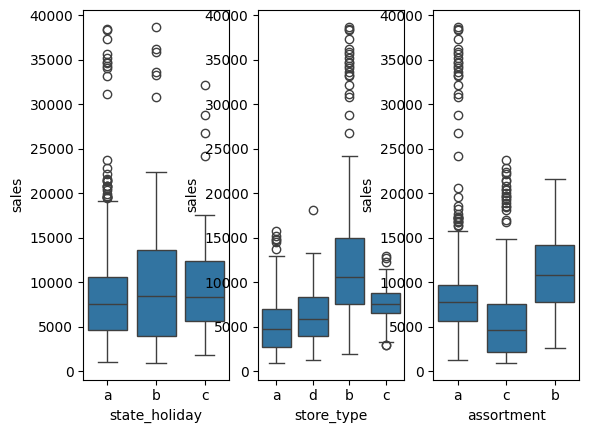

In [362]:
#filtro para pegar dados diferentes de 0 e coluna vendas maior que zero
aux1 = df1[(df1["state_holiday"] != "0") & (df1["sales"] > 0)]
plt.subplot(1, 3, 1)
sns.boxplot(x="state_holiday", y="sales", data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x="store_type", y="sales", data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x="assortment", y="sales", data=aux1)

# 2.0 passo 02 - FEATURE ENGINEERING

In [363]:
df2 = df1.copy()

In [364]:
# from IPython.display import Image
Image( "img/MindMapHypothesis.png")

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

FileNotFoundError: No such file or directory: 'img/MindMapHypothesis.png'

<IPython.core.display.Image object>

### 2.1 Mapa mental de hipoteses

## 2.1 Criação das hipoteses 

## 2.1.1 hipoteses loja

**1.** - Lojas com maior numero de funcionarios deveriam vender mais.
**2.** - Lojas com maior estoque deveriam vender mais.
**3.** - lojas com maior porte deveriam vender mais.
**4.** - lojas com menor porte deveriam vender menos.
**5.** - lojas com maior sortimento deveriam vender mais.

## 2.1.2 hipoteses produto

**1.** - Lojas que investem mais em marketing deveriam vender mais.
**2.** - lojas que expoe mais o produto nas vitrinis deveriam vender mais.
**3.** - lojas que tem preços menores nos produtos deveriam vender mais.
**4.** - lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.


## 2.1.3 hipoteses tempo

**1.** - Lojas que tem mais feriados deveriam vender menos.
**2.** - lojas que abrem nos primeiros 6 meses deveriam vender mais.
**3.** - lojas que abrem nos finais de semana deveriam vender mais.

## 2.2 Lista final de hipoteses

**1.** - Lojas que tem mais feriados deveriam vender menos.
**2.** - lojas que abrem nos primeiros 6 meses deveriam vender mais.
**3.** - lojas que abrem nos finais de semana deveriam vender mais.
**4.** - lojas com maior sortimento deveriam vender mais.
**5.** - lojas com competidores mais proximos deveriam vender menos.
**6.** - lojas com competidores a mais tempo deveriam vender mais
**7.** - lojas com promoções ativas por mais tempo deveriam vender mais.
**8.** - lojas com promoções consecutivas a mais tempo deveriam vender mais.

1. Lojas com maior sortimentos deveriam vender mais. 
2. Lojas com competidores mais próximos deveriam vender menos. 
3. Lojas com competidores à mais tempo deveriam vendem mais. 
4. Lojas com promoções ativas por mais tempo deveriam vender mais. 
5. Lojas com mais dias de promoção deveriam vender mais. 
7. Lojas com mais promoções consecutivas deveriam vender mais. 
8. Lojas abertas durante o feriado de Natal deveriam vender mais. 
9. Lojas deveriam vender mais ao longo dos anos. 
10. Lojas deveriam vender mais no segundo semestre do ano. 
11. Lojas deveriam vender mais depois do dia 10 de cada mês. 
12. Lojas deveriam vender menos aos finais de semana. 
13. Lojas deveriam vender menos durante os feriados escolares.

## Feature Engineering

In [365]:
# year
df2["year"] = df2["date"].dt.year
# month
df2["month"] = df2["date"].dt.month

# day
df2["day"] = df2["date"].dt.day

# week of year
df2["week_of_year"] = df2["date"].dt.day_of_week
df2["year_week"] = df2["date"].dt.strftime("%Y-%w")
import datetime
# competition since
df2["competition_since"] = df2.apply(lambda x: datetime.datetime(year=x["competition_open_since_year"], month=x["competition_open_since_month"], day=1), axis=1)
df2["compatition_time_month"] = ((df2["date"] - df2["competition_since"] )/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2["promo_time_week"] = ((df2["date"] - df2["promo_since"]) /7).apply(lambda x: x.days).astype(int)

#
# assortment
df2["assortment"] = df2["assortment"].apply( lambda x: "basic" if x == "a" else "extra" if x == "b" else "extended" )

# state holiday 
df2["state_holiday"] = df2["state_holiday"].apply( lambda x: "public_holiday" if x == "a" else "Easter_holiday" if x == "b" else "christmas" if x == "c"  else "regular_day")


In [366]:
df2.sample().T

,71985
store,626
day_of_week,4
date,2015-05-28 00:00:00
sales,7878
customers,769
open,1
promo,0
state_holiday,regular_day
school_holiday,0
store_type,c


# 3.0 PASSO 03 - Filtragem de variaveis 

In [367]:
df3 = df2.copy()

In [368]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,compatition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,4,2015-5,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,4,2015-5,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,4,2015-5,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,4,2015-5,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,4,2015-5,2015-04-01,4,2015-07-27,0


## 3.1 Filtragem de Linhas

In [369]:
df3 = df3[(df3["open"] != 0) & (df3["sales"] > 0)]

## 3.2 Filtragem das Linhas

In [370]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,compatition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,4,2015-5,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,4,2015-5,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,4,2015-5,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,4,2015-5,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,4,2015-5,2015-04-01,4,2015-07-27,0


## Filtragem das Colunas

In [371]:
cols_drop = ["customers","open", "month_map"]
df3.drop(cols_drop, axis=1)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,compatition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,4,2015-5,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,4,2015-5,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,4,2015-5,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,4,2015-5,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,4,2015-5,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,...,0,2013,1,1,1,2013-2,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,...,0,2013,1,1,1,2013-2,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,...,1,2013,1,1,1,2013-2,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,...,0,2013,1,1,1,2013-2,2013-01-01,0,2012-12-31,0


# Modulo 04 - Passo 04 - Analise exploratoria dos dados

In [372]:
df4 = df3.copy()

In [373]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'compatition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.1 Analise univariada

### 4.1.1 Response variable

<Axes: xlabel='sales', ylabel='Density'>

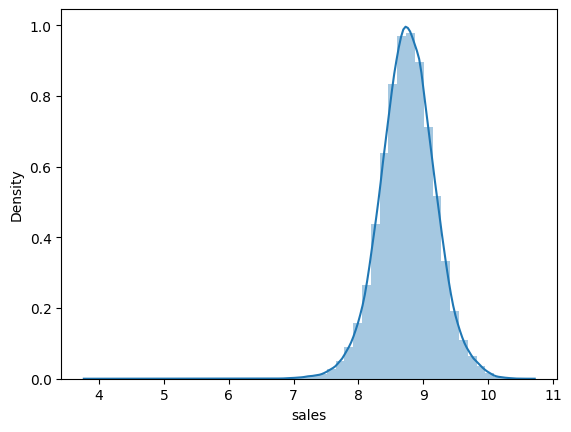

In [374]:
sns.distplot( np.log1p(df4["sales"]))

## 4.2 Analise bivariada

### 4.2.2 Numerical variable

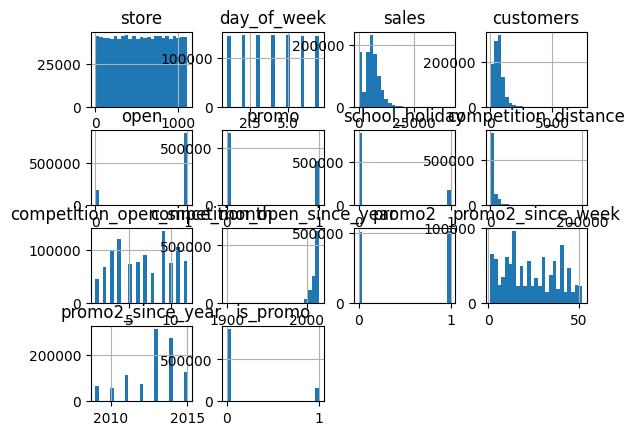

In [375]:
num_attributes.hist(bins=25);

4.1.3 Categorical variable

In [376]:
df4["state_holiday"].drop_duplicates

<bound method Series.drop_duplicates of 0             regular_day
1             regular_day
2             regular_day
3             regular_day
4             regular_day
                ...      
1016776    public_holiday
1016827    public_holiday
1016863    public_holiday
1017042    public_holiday
1017190    public_holiday
Name: state_holiday, Length: 844338, dtype: object>

<Axes: xlabel='sales', ylabel='Density'>

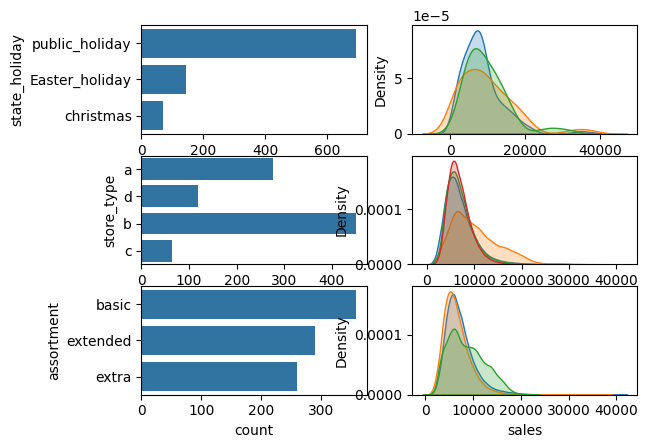

In [377]:
# state_holiday
plt.subplot(3,2,1)
a = df4[df4["state_holiday"] != "regular_day"]
sns.countplot(a["state_holiday"])
plt.subplot(3,2,2)
sns.kdeplot(df4[df4["state_holiday"] == "public_holiday"] ["sales"], label="public_holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "Easter_holiday"] ["sales"], label="easter_holiday", shade=True)
sns.kdeplot(df4[df4["state_holiday"] == "christmas"] ["sales"], label="christmas", shade=True)
# store_type
plt.subplot(3,2,3)
sns.countplot(a["store_type"])
plt.subplot(3,2,4)
sns.kdeplot(df4[df4["store_type"] == "a"] ["sales"], label="public_holiday", shade=True)
sns.kdeplot(df4[df4["store_type"] == "b"] ["sales"], label="easter_holiday", shade=True)
sns.kdeplot(df4[df4["store_type"] == "c"] ["sales"], label="christmas", shade=True)
sns.kdeplot(df4[df4["store_type"] == "d"] ["sales"], label="christmas", shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(a["assortment"])
plt.subplot(3,2,6)
sns.kdeplot(df4[df4["assortment"] == "extended"] ["sales"], label="extended", shade=True)
sns.kdeplot(df4[df4["assortment"] == "basic"] ["sales"], label="basic", shade=True)
sns.kdeplot(df4[df4["assortment"] == "extra"] ["sales"], label="extra", shade=True)


## 4.2 Analise Bivariada

1. Lojas com maior sortimentos deveriam vender mais. 
2. Lojas com competidores mais próximos deveriam vender menos. 
3. Lojas com competidores à mais tempo deveriam vendem mais. 
4. Lojas com promoções ativas por mais tempo deveriam vender mais. 
5. Lojas com mais dias de promoção deveriam vender mais. 
7. Lojas com mais promoções consecutivas deveriam vender mais. 
8. Lojas abertas durante o feriado de Natal deveriam vender mais. 
9. Lojas deveriam vender mais ao longo dos anos. 
10. Lojas deveriam vender mais no segundo semestre do ano. 
11. Lojas deveriam vender mais depois do dia 10 de cada mês. 
12. Lojas deveriam vender menos aos finais de semana. 
13. Lojas deveriam vender menos durante os feriados escolares.

### 1. Lojas com maior sortimentos deveriam vender mais. 


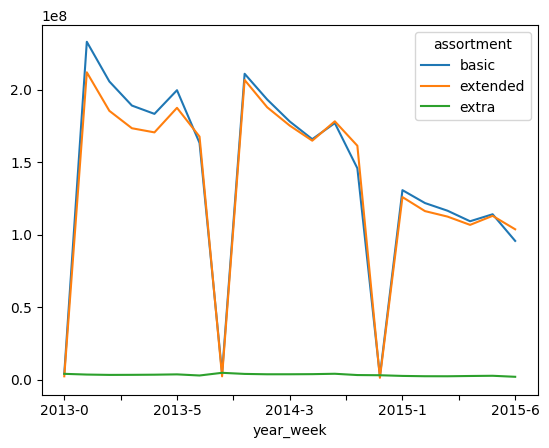

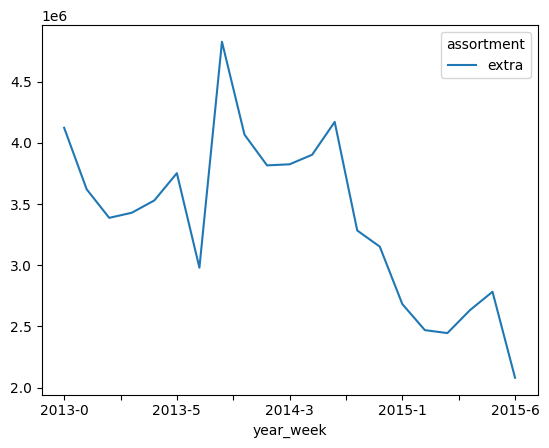

In [378]:
aux2 = df4[["assortment","sales"]].groupby("assortment").sum().reset_index()
#sns.barplot(x="assortment", y="sales", data=aux2);

aux3 = df4[["year_week", "assortment","sales"]].groupby(["year_week","assortment"]).sum().reset_index()
aux3.pivot(index="year_week", columns="assortment", values="sales").plot();

aux4 = aux3[aux3["assortment"] == "extra"]
aux4.pivot(index="year_week", columns="assortment", values="sales").plot();

# Resposta: lojas com maior assortment vendem menos.

In [379]:
aux4.head()

,year_week,assortment,sales
2,2013-0,extra,4122443
5,2013-1,extra,3619619
8,2013-2,extra,3386525
11,2013-3,extra,3428282
14,2013-4,extra,3528782


### 2. Lojas com competidores mais próximos deveriam vender menos. 

2. falsa, pois como observamos lojas com competidores mais proximos vedem mais.

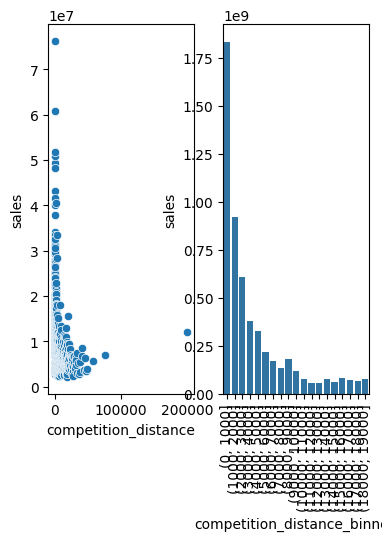

In [380]:

aux_1 = df4[["competition_distance", "sales"]].groupby("competition_distance").sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x= "competition_distance", y="sales", data= aux_1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000,1000)) # ou seja parte de 0 ate 20k de 1000 em 1000 # agora estou criando uma nova coluna com o metodo cut do pandas
aux_1["competition_distance_binned"] = pd.cut(aux_1["competition_distance"], bins=bins)
aux_2 = aux_1[["competition_distance_binned", "sales"]].groupby("competition_distance_binned").sum().reset_index()
sns.barplot(x="competition_distance_binned", y="sales", data=aux_2);
plt.xticks(rotation=90);

#aux_1new = aux_1.select_dtypes(include=[np.number])  # Mantém apenas colunas numéricas

#plt.subplot(1, 3, 3)
#sns.heatmap(aux1.corr(method="pearson"), annot=True);
#bottom, top = x.get_ylim()
#x.set_ylim(bottom+0.5, top-0.5 );
#sns.heatmap(aux_1.corr(method="pearson"), annot=True);


# pelo o que estamos vendo no grafico é completamente diferente do que acreditavamos, regioes proximas vendem mais
# falsa a premissa da hipotese.

# quando temos graficos muito granulares podemos usar o scatter 


### 3. Lojas com competidores à mais tempo deveriam vendem mais. 

3. Falsa, as lojas com competidores por mais tempo, vendem menos. Conforme podemos ver abaixo:

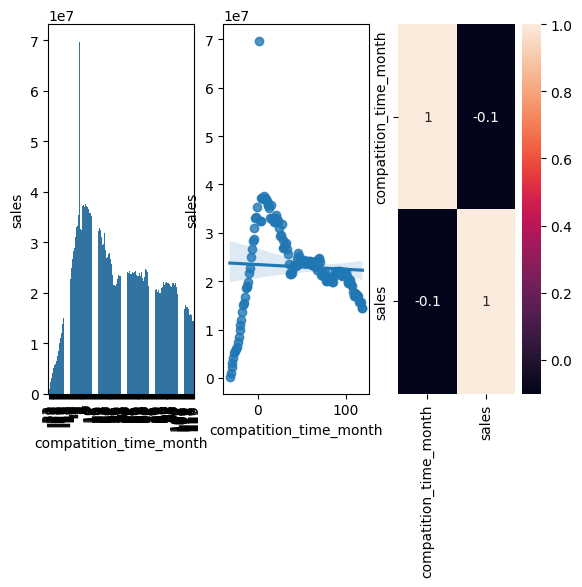

In [381]:
plt.subplot(1,3,1)
aux__1 = df4[["compatition_time_month", "sales"]].groupby("compatition_time_month").sum().reset_index()
aux__2 = aux__1[(aux__1["compatition_time_month"] < 120) & (aux__1["compatition_time_month"] != 0)]
sns.barplot(x="compatition_time_month", y="sales", data=aux__2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x="compatition_time_month",y="sales", data=aux__2)

plt.subplot(1,3,3)
sns.heatmap(aux__1.corr(method="pearson"), annot=True);


4. Lojas com promoções ativas por mais tempo deveriam vender mais. 
5. Lojas com mais dias de promoção deveriam vender mais. 
7. Lojas com mais promoções consecutivas deveriam vender mais. 

4. Lojas com promoções ativas por mais tempo deveriam vender mais. 


 eu vou pular estas questoes.../

## 4.3 Analise Multivariada

### 4.3.1. Numerical Atributes

<Axes: >

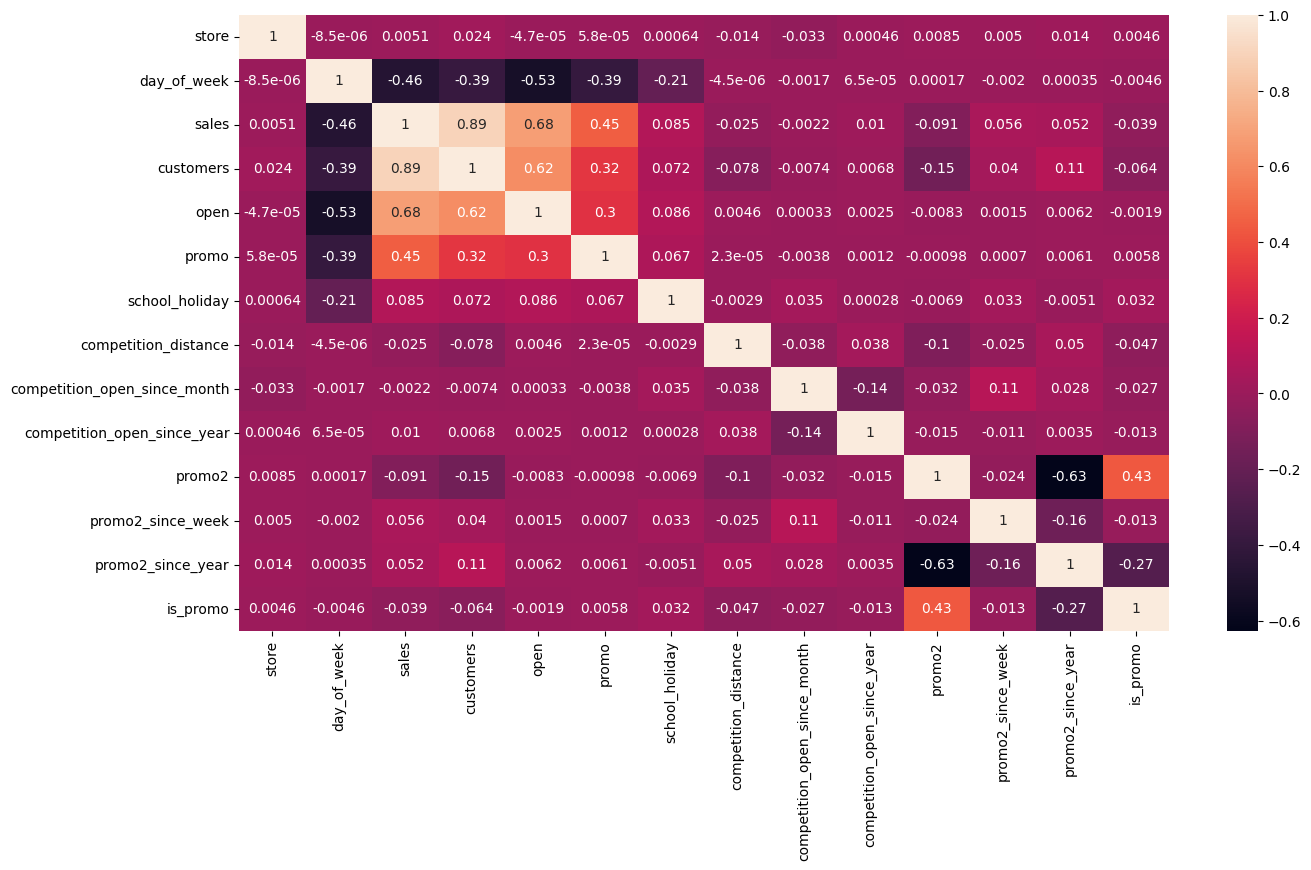

In [382]:
plt.figure(figsize=(15,8))
correlation = num_attributes.corr(method="pearson")
sns.heatmap(correlation, annot=True)

### 4.3.1. Categorical Atributes

In [383]:
from scipy import stats as ss

In [384]:
a = df4.select_dtypes(include="object")

In [385]:
a.head()

,state_holiday,store_type,assortment,promo_interval,month_map,year_week
0,regular_day,c,basic,0,Jul,2015-5
1,regular_day,a,basic,"Jan,Apr,Jul,Oct",Jul,2015-5
2,regular_day,a,basic,"Jan,Apr,Jul,Oct",Jul,2015-5
3,regular_day,c,extended,0,Jul,2015-5
4,regular_day,a,basic,0,Jul,2015-5


In [386]:
cm = pd.crosstab(a["state_holiday"], a["store_type"]).values # temos que passar para array, nesta versao do pandas nao temos o as_matrix() entao foi usado o .value

In [387]:
chi2 = ss.chi2_contingency(cm)[0] # cm confusion matrix -ou crosstab tabela de contingencia ele faz as combinaçoes e conta o numero de linhas

In [388]:
chi2 # ki quadrado esta pronto
n = cm.sum()
r, k = cm.shape


In [389]:
v = np.sqrt((chi2/n) / (min(k-1, r-1)) )

In [390]:
print("O valor é: ", v)

O valor é:  0.07106457093267678


In [391]:
# Podemos criar uma função com esta equaçao de cramer

def cramer(x, y):
    cm = pd.crosstab(x, y).values # temos que passar para array, nesta versao do pandas nao temos o as_matrix() entao foi usado o .value
    n = cm.sum()
    chi2 = ss.chi2_contingency(cm)[0] # cm confusion matrix -ou crosstab tabela de contingencia ele faz as combinaçoes e conta o numero de linhas
    r, k = cm.shape # r = linas rows e k = colunas colums
    return np.sqrt((chi2/n) / (min(k-1, r-1)) )


In [392]:
cramer(a["state_holiday"], a["store_type"])

0.07106457093267678

### Temos que fazer o Bias Corretion que regula a força do vies ele pode sobreestimar os dados

In [393]:

def cramerBiasCorr(x, y):
    cm = pd.crosstab(x, y).values # temos que passar para array, nesta versao do pandas nao temos o as_matrix() entao foi usado o .value
    n = cm.sum()
    r, k = cm.shape # r = linas rows e k = colunas colums
    chi2 = ss.chi2_contingency(cm)[0] # cm confusion matrix -ou crosstab tabela de contingencia ele faz as combinaçoes e conta o numero de linhas
    chi2corr = max(0, chi2 - (k-1) * (r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)) )



In [394]:
cramerBiasCorr(a["state_holiday"], a["store_type"])

0.07106469715258833

Vamos criar a matrix

In [395]:
a1 = cramerBiasCorr(a["state_holiday"], a["state_holiday"])
a2 = cramerBiasCorr(a["state_holiday"], a["store_type"])
a3 = cramerBiasCorr(a["state_holiday"], a["assortment"])

a4 = cramerBiasCorr(a["store_type"], a["state_holiday"])
a5 = cramerBiasCorr(a["store_type"], a["store_type"])
a6 = cramerBiasCorr(a["store_type"], a["assortment"])

a7 = cramerBiasCorr(a["assortment"], a["state_holiday"])
a8 = cramerBiasCorr(a["assortment"], a["store_type"])
a9 = cramerBiasCorr(a["assortment"], a["assortment"])

d = pd.DataFrame({"state_holiday" : [a1, a2, a3],
              "store_type" : [a4, a5, a6],
            "assortment" :[a7, a8, a9]})

d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<Axes: >

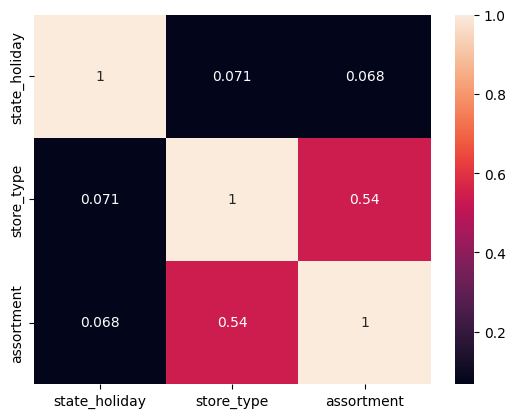

In [396]:

sns.heatmap(d, annot=True)

# 5.0 PASSO 05 - DATA PREPARATION

In [397]:
df5 = df4.copy()

## 5.1 Normalização

Os dados nao sao uma distribuição normal, portanto nao faremos a normalização

## 5.2 Rescaling

In [398]:
a = df5.select_dtypes(include=["int64","float64", "int32"])

In [399]:
df5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int32
month        

In [400]:
a.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,compatition_time_month,promo_time_week
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,4,84,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,4,94,279
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,4,105,226
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,4,71,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,4,4,0


Vamos escolher quais variaveis vamos aplicar o MIN mAX

<Axes: ylabel='competition_distance'>

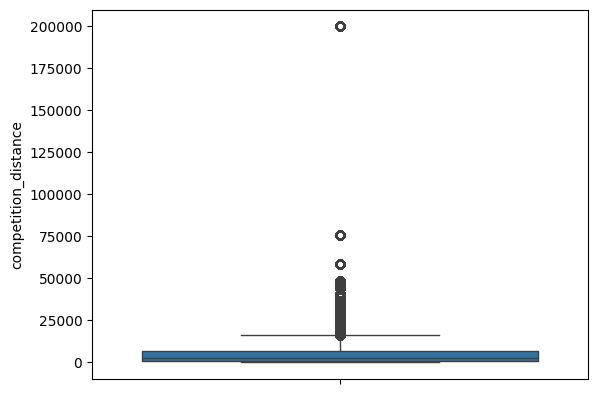

In [401]:
sns.boxplot(df5["competition_distance"])

<Axes: ylabel='compatition_time_month'>

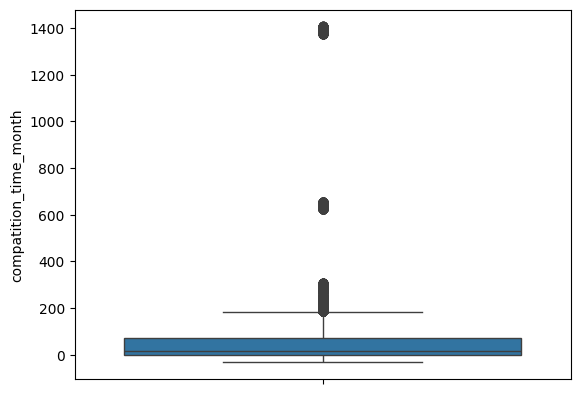

In [402]:
sns.boxplot(df5["compatition_time_month"])
# temos outlier tambem

In [403]:
from sklearn.preprocessing import RobustScaler,  MinMaxScaler
# g

In [404]:
df5.columns.T

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_map', 'is_promo', 'year',
       'month', 'day', 'week_of_year', 'year_week', 'competition_since',
       'compatition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [405]:
# temos que ver se iremos utilizar o min max scaler ou o Robust - o que determina é se tem outlier ou nao
# competition_distance - Robust scaler pois temos outlier (colocado por nos em outro passo para remover o NA)
#rs = RobustScaler()
#mms = MinMaxScaler()
#df5["competition_distance"] = rs.fit_transform(df5[["competition_distance"]].values)


# compatition_time_month
#df5["compatition_time_month"] = rs.fit_transform(df5[["compatition_time_month"]].values)

# year (ciclico)

#df5["year"] = mms.fit_transform(df5[["year"]].values)

# day_of_week

rs = RobustScaler()
mms = MinMaxScaler()

# estou colocando tudo dentro do arquivo pickle para ser acessado pela API
# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump( rs, open( '/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/webapp/parameter/competition_distance_scaler.pkl', 'wb') )

# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[['compatition_time_month']].values )
pickle.dump( rs, open( '/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/webapp/parameter/competition_time_month_scaler.pkl', 'wb') )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump( rs, open( '/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/webapp/parameter/promo_time_week_scaler.pkl', 'wb') )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump( mms, open( '/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/webapp/parameter/year_scaler.pkl', 'wb') )

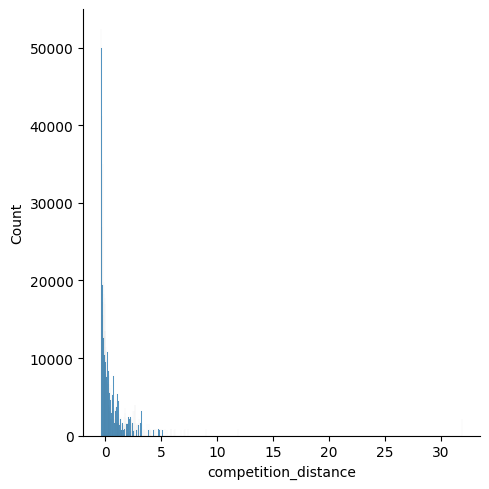

In [406]:
sns.displot(df5["competition_distance"])

In [407]:
# year (ciclico)
# month (ciclico)
# day (ciclico)
# week_of_year (ciclico)


## 5.3 Transformação

### 5.3.1 Encoding

In [408]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,year,month,day,week_of_year,year_week,competition_since,compatition_time_month,promo_since,promo_time_week,competition_time_month
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,1.0,7,31,4,2015-5,2008-09-01,84,2015-07-27,0.287016,0.918919
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1.0,7,31,4,2015-5,2007-11-01,94,2010-03-22,0.922551,1.054054
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1.0,7,31,4,2015-5,2006-12-01,105,2011-03-28,0.801822,1.202703
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,1.0,7,31,4,2015-5,2009-09-01,71,2015-07-27,0.287016,0.743243
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,1.0,7,31,4,2015-5,2015-04-01,4,2015-07-27,0.287016,-0.162162


In [409]:
# state_holiday - Vamos usar o One hot encoding
df5 = pd.get_dummies(df5, prefix=["state_holiday"], columns=["state_holiday"])


In [410]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,...,year_week,competition_since,compatition_time_month,promo_since,promo_time_week,competition_time_month,state_holiday_Easter_holiday,state_holiday_christmas,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,c,basic,...,2015-5,2008-09-01,84,2015-07-27,0.287016,0.918919,False,False,False,True
1,2,5,2015-07-31,6064,625,1,1,1,a,basic,...,2015-5,2007-11-01,94,2010-03-22,0.922551,1.054054,False,False,False,True
2,3,5,2015-07-31,8314,821,1,1,1,a,basic,...,2015-5,2006-12-01,105,2011-03-28,0.801822,1.202703,False,False,False,True
3,4,5,2015-07-31,13995,1498,1,1,1,c,extended,...,2015-5,2009-09-01,71,2015-07-27,0.287016,0.743243,False,False,False,True
4,5,5,2015-07-31,4822,559,1,1,1,a,basic,...,2015-5,2015-04-01,4,2015-07-27,0.287016,-0.162162,False,False,False,True


In [411]:
# store_type - Nao tem uma ordem para esta coluna. Vamos usar um label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df5["store_type"] = le.fit_transform(df5["store_type"])


# state_holiday - One Hot Encoding
#df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )
pickle.dump( le, open( '/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/webapp/parameter/store_type_scaler.pkl', 'wb') )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )


In [412]:
df5.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval', 'month_map',
       'is_promo', 'year', 'month', 'day', 'week_of_year', 'year_week',
       'competition_since', 'compatition_time_month', 'promo_since',
       'promo_time_week', 'competition_time_month',
       'state_holiday_Easter_holiday', 'state_holiday_christmas',
       'state_holiday_public_holiday', 'state_holiday_regular_day'],
      dtype='object')

In [413]:
df5.head() # veja que foi trocado as letras pelos numeros

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,...,year_week,competition_since,compatition_time_month,promo_since,promo_time_week,competition_time_month,state_holiday_Easter_holiday,state_holiday_christmas,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,2,1,...,2015-5,2008-09-01,84,2015-07-27,0.287016,0.918919,False,False,False,True
1,2,5,2015-07-31,6064,625,1,1,1,0,1,...,2015-5,2007-11-01,94,2010-03-22,0.922551,1.054054,False,False,False,True
2,3,5,2015-07-31,8314,821,1,1,1,0,1,...,2015-5,2006-12-01,105,2011-03-28,0.801822,1.202703,False,False,False,True
3,4,5,2015-07-31,13995,1498,1,1,1,2,3,...,2015-5,2009-09-01,71,2015-07-27,0.287016,0.743243,False,False,False,True
4,5,5,2015-07-31,4822,559,1,1,1,0,1,...,2015-5,2015-04-01,4,2015-07-27,0.287016,-0.162162,False,False,False,True


In [414]:
df5["assortment"].drop_duplicates() # veja que tem uma ordem basic e menor que extra e menor que extended
# neste caso podemos usar esta mesma ordem com o endoding ordinal

0      1
3      3
258    2
Name: assortment, dtype: int64

In [415]:
# assortment
#assortment_dict = {"basic": 1, "extra": 2, "extended":3}
#df5["assortment"] = df5["assortment"].map(assortment_dict) # estamos usando o dicionario criado acima para passar os valores, estamos usando o metodo map para passar por cada linha
# sera feito a substituicao tudo que for basic sera igual a 1 e extra 2 extended 3


In [416]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,...,year_week,competition_since,compatition_time_month,promo_since,promo_time_week,competition_time_month,state_holiday_Easter_holiday,state_holiday_christmas,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,555,1,1,1,2,1,...,2015-5,2008-09-01,84,2015-07-27,0.287016,0.918919,False,False,False,True
1,2,5,2015-07-31,6064,625,1,1,1,0,1,...,2015-5,2007-11-01,94,2010-03-22,0.922551,1.054054,False,False,False,True
2,3,5,2015-07-31,8314,821,1,1,1,0,1,...,2015-5,2006-12-01,105,2011-03-28,0.801822,1.202703,False,False,False,True
3,4,5,2015-07-31,13995,1498,1,1,1,2,3,...,2015-5,2009-09-01,71,2015-07-27,0.287016,0.743243,False,False,False,True
4,5,5,2015-07-31,4822,559,1,1,1,0,1,...,2015-5,2015-04-01,4,2015-07-27,0.287016,-0.162162,False,False,False,True


### 5.3.2 Response Variable Transformation 

In [417]:
df5["sales"] = np.log1p( df5["sales"])

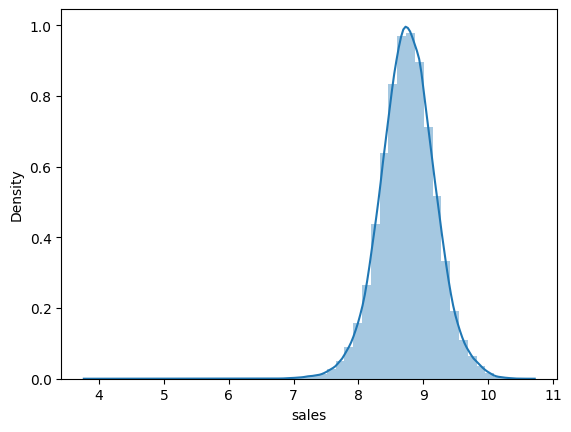

In [418]:
sns.distplot(df5["sales"]);

### 5.3.2 Nature transformation

In [419]:
# day_of_week

df5["day_of_week_sin"] = df5["day_of_week"].apply(lambda x: np.sin(x * (2. * np.pi/7 ) ) ) # 7 pois a cada semana temos 7 dias
df5["day_of_week_cos"] = df5["day_of_week"].apply(lambda x: np.cos(x * (2. * np.pi/7 ) ) ) # 7 pois a cada semana temos 7 dias

# year
# nao repitimos o ano, entao nao temos ciclos
# month
df5["month_sin"] = df5["month"].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) ) # 
df5["month_cos"] = df5["month"].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) ) # 

# day
df5["day_sin"] = df5["day"].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) ) # 30 e a media de dias no mes
df5["day_cos"] = df5["day"].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) ) # 30 e a media de dias no mes
# week_of_year

df5["week_of_year_sin"] = df5["week_of_year"].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) ) # 52 semanas no ano
df5["week_of_year_cos"] = df5["week_of_year"].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) ) # 52 semanas no ano

# year_week

In [420]:
df5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,555,1,1,1,2,1,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025,0.866025,-0.5
1,2,5,2015-07-31,8.710290,625,1,1,1,0,1,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025,0.866025,-0.5
2,3,5,2015-07-31,9.025816,821,1,1,1,0,1,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025,0.866025,-0.5
3,4,5,2015-07-31,9.546527,1498,1,1,1,2,3,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025,0.866025,-0.5
4,5,5,2015-07-31,8.481151,559,1,1,1,0,1,...,False,True,-0.974928,-0.222521,-0.5,-0.866025,-0.5,-0.866025,0.866025,-0.5


# 6.0. PASSO 06 - FEATURE SELECTION

In [421]:
# é importante fazer a copia do Dataframe do passo anterior, para nao ter que fazer o run de tudo novamente.
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [422]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )  # axis=1 significa ao logo das linhas, para deletar a coluna inteira

In [423]:
# Overfit o modelo decora os dados
# nao podemos passar todos os dados pois temos diferentes linhas de tempo se passar tudo teremos dados do passado e ano futuro chances de overfit
# vamos pegar as ultimas 6 semanas e separar para os dados de teste
# tudo que for anterior as 6 semanas serao nosso dado de treino
df6[[ "store", "date"]].groupby("store").min().reset_index() # 2013-01-02
df6[[ "store", "date"]].groupby("store").max().reset_index() # 2015-07-31


,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [424]:
df6[[ "store", "date"]].groupby("store").max().reset_index()["date"][0] - datetime.timedelta(days=6*7)
# este datetime com o timedelta me fornece a data conforme filtro days e faco - a ultima data do dataset


Timestamp('2015-06-19 00:00:00')

In [425]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [426]:
from boruta import BorutaPy

In [427]:
df6.isna().sum()

store                           0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
year                            0
compatition_time_month          0
promo_time_week                 0
competition_time_month          0
state_holiday_Easter_holiday    0
state_holiday_christmas         0
state_holiday_public_holiday    0
state_holiday_regular_day       0
day_of_week_sin                 0
day_of_week_cos                 0
month_sin                       0
month_cos     

In [428]:
X_train.head().T # ele ainda esta com 2 var que nao podemos usar - date - sales

,47945,47946,47947,47948,47949
store,1,2,3,4,5
date,2015-06-18 00:00:00,2015-06-18 00:00:00,2015-06-18 00:00:00,2015-06-18 00:00:00,2015-06-18 00:00:00
sales,8.443762,8.547722,8.927712,9.091669,8.50208
customers,498,594,743,1138,545
open,1,1,1,1,1
promo,1,1,1,1,1
school_holiday,0,0,0,0,0
store_type,2,0,0,2,0
assortment,1,1,1,3,1
competition_distance,-0.170968,-0.283871,1.903226,-0.275806,4.448387


In [429]:
from sklearn.ensemble import RandomForestRegressor


In [430]:
# training and test dateset for Boruta
#x_train_n =x_train.drop(["date", "sales", "promo_interval", "month_map", "promo2_since_year", "year_week", "competition_distance"], axis=1).values # eu estou dropando as 2 colunas para treinar o modelo
#y_train_n = y_train.values.ravel() # ravel coloca tudo dentro de um vetor

# define randomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators="auto", verbose=2, random_state=42 ).fit(x_train_n, y_train_n) # random faz com que o modelo parta do mesmo inicio

In [431]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns, cols_selected_boruta ) )

In [432]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. PASSO 07 - MACHINE LEARNING MODELLING

In [316]:
X_train.columns

Index(['store', 'date', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'promo_interval', 'month_map',
       'is_promo', 'year', 'compatition_time_month', 'promo_time_week',
       'competition_time_month', 'state_holiday_Easter_holiday',
       'state_holiday_christmas', 'state_holiday_public_holiday',
       'state_holiday_regular_day', 'day_of_week_sin', 'day_of_week_cos',
       'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [433]:
 # variaveis so as relevantes sem date e vendas
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
# o x minuscolo e o dataset com todos os dados relevantes + date + vendas 
x_training = X_train[ cols_selected_boruta_full ]

### Vamos começar como o modelo de Media

In [434]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


In [435]:
X_train = x_train[ cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

In [436]:
from sklearn import metrics as mt

In [437]:
def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y, yhat)
    mape = mt.mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mt.mean_squared_error(y, yhat))

    return pd.DataFrame(
        {
            "Model Name": [model_name],  # Coloque entre colchetes para criar uma lista
            "MAE": [mae],
            "MAPE": [mape],
            "RMSE": [rmse],
        }, 
        index=[0]  # index fora do dicionário
    )

In [438]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## Linear Regression

In [323]:
from sklearn.linear_model import LinearRegression, Lasso

In [324]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)
# model
lr_result = ml_error("linear Regression", np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,linear Regression,1870.46614,0.291842,2676.136897


## 7.3 Linear regression regularized model

In [325]:
x_train.isna().sum()

store                           0
promo                           0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
competition_time_month          0
promo_time_week                 0
day_of_week_sin                 0
day_of_week_cos                 0
month_sin                       0
month_cos                       0
day_sin                         0
day_cos                         0
week_of_year_sin                0
week_of_year_cos                0
dtype: int64

In [326]:
# model LASSO
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)
# model
lrr_result = ml_error("linear Regression - Lasso", np.expm1(y_test), np.expm1(yhat_lrr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,linear Regression,1870.46614,0.291842,2676.136897


### 7.3.1.  Lasso - Cross Validation

In [327]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2115.65 +/- 337.3,0.29 +/- 0.01,3056.53 +/- 499.38


## 7.4 Random Forest Regressor

In [328]:
from sklearn.ensemble import RandomForestRegressor

In [329]:
# model Random forest - 
# o n_estimator e o numero de arvores que o modelo vai c
# random state mesma origem aleatoria
# n_jobs = rodar paralelo
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)
# model
rf_result = ml_error("Randon forest", np.expm1(y_test), np.expm1(yhat_rf))
rf_result

KeyboardInterrupt: 

### 7.4.1.  Random Forest Regressor - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose=True )
rf_result_cv

## XGBoost Regressor

In [ ]:
import xgboost  as xgb

In [ ]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

### 7.5.1. XGBoost Regressor - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True )
xgb_result_cv

## 7.6. Compare Model's Performance

In [ ]:
def cross_validation( x_training, kfold, model_name, model, verbose=False ):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range( 1, kfold+1 ) ):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta( days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta( days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop( ['date', 'sales'], axis=1 ) 
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop( ['date', 'sales'], axis=1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat ) )

        # store performance of each kfold iteration
        mae_list.append(  m_result['MAE'] )
        mape_list.append( m_result['MAPE'] )
        rmse_list.append( m_result['RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


### 7.6.1. Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

### 7.6.2. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv

# 8.0. PASSO 08 - HYPERPARAMETER FINE TUNING

## 8.1. Random Search

In [309]:
import random
import warnings
warnings.filterwarnings("ignore")

In [310]:
# param = {
#     "n_estimators": [15,17, 25, 30, 35],
#     "eta": [0.01, 0.03],
#     "max_depth": [3, 5, 9],
#     "subsample": [0.1, 0.5, 0.7],
#     "colsample_bytee": [0.3, 0.7, 0.9],
#     "min_child_weight": [3, 8, 15]
# }

# MAX_EVAL = 2

In [ ]:
# final_result = pd.DataFrame()

# for i in range (MAX_EVAL):
#     # choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     random.sample
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                 n_estimators=hp["n_estimators"], 
#                                 eta=hp["eta"], 
#                                 max_depth=hp["max_depth"], 
#                                 subsample=hp["subsample"],
#                                 colsample_bytree=hp["colsample_bytree"],
#                                 min_child_weight=hp["min_child_weight"] )

#     # prediction
#     yhat_xgb = model_xgb.predict( x_test )

# # performance cross_validation( x_training, kfold, model_name, model, verbose=False ):
# result = cross_validation( x_training, 2, "XGboost Regressor", model_xgb, verbose=False )
# final_result = pd.concat([final_result, result]) # estou concatenando o resultado com o novo data frame

# final_result


## 8.2. Final Model

In [439]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [440]:
x_train.columns

Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [450]:
x_test.columns

Index(['store', 'promo', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'competition_time_month',
       'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_sin',
       'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin',
       'week_of_year_cos'],
      dtype='object')

In [441]:
# model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'], 
                                    eta=param_tuned['eta'], 
                                    max_depth=param_tuned['max_depth'], 
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,778.295146,0.116741,1123.768864


In [442]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.024866296112110005

# 9.0. PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [443]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

KeyError: "['date', 'sales'] not in index"

## 9.1. Business Performance

In [ ]:
# sum of predictions
df91 = df9[["store", "predications"]].groupby("store").sum().reset_index()

# MAE e MAPE
df9[["store","sales", "prediction"]].groupby("store").apply(lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[["store", "sales", "predictions"]].groupby( "store" ).apply( lambda x: mean_absolute_percentage_error( x["sales"], x["predictions"] ) ).reset_index().rename( columns={0:"MAPE"})

In [ ]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

## 9.2. Total Performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

## 9.3. Machine Learning Performance

df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [ ]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0. PASSO 10 - DEPLOY MODEL TO PRODUCTION

In [451]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/webapp/model/model_rossmann.pkl', 'wb' ) )

## 10.1 Rossman Class

In [452]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann( object ):
    def __init__( self ):
        self.home_path='//Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/'
        self.competition_distance_scaler   = pickle.load( open( self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb') )
        self.competition_time_month_scaler = pickle.load( open( self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb') )
        self.promo_time_week_scaler        = pickle.load( open( self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb') )
        self.year_scaler                   = pickle.load( open( self.home_path + 'parameter/year_scaler.pkl', 'rb') )
        self.store_type_scaler             = pickle.load( open( self.home_path + 'parameter/store_type_scaler.pkl', 'rb') )
        
        
    def data_cleaning( self, df1 ): 
        
        ## 1.1. Rename Columns
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # rename
        df1.columns = cols_new

        ## 1.3. Data Types
        df1['date'] = pd.to_datetime( df1['date'] )

        ## 1.5. Fillout NA
        #competition_distance        
        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

        #competition_open_since_year 
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        #promo2_since_week           
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

        #promo2_since_year           
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        #promo_interval              
        month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True )

        df1['month_map'] = df1['date'].dt.month.map( month_map )

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

        ## 1.6. Change Data Types
        # competiton
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        # promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1 


    def feature_engineering( self, df2 ):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS
        ## 3.1. Filtragem das Linhas
        df2 = df2[df2['open'] != 0]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2


    def data_preparation( self, df5 ):

        ## 5.2. Rescaling 
        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )
    
        # competition time month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )
        
        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        ### 5.3.1. Encoding
        # state_holiday - One Hot Encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

        # store_type - Label Encoding
        df5['store_type'] = self.store_type_scaler.fit_transform( df5['store_type'] )

        # assortment - Ordinal Encoding
        assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map( assortment_dict )

        
        ### 5.3.3. Nature Transformation
        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

        # month
        df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

        # day 
        df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )
        
        
        cols_selected = [ 'store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
            'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
            'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'week_of_year_sin', 'week_of_year_cos']
        
        return df5[ cols_selected ]
    
    
    def get_prediction( self, model, original_data, test_data ):
        # prediction
        pred = model.predict( test_data )
        
        # join pred into the original data
        original_data['prediction'] = np.expm1( pred )
        
        return original_data.to_json( orient='records', date_format='iso' )

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/meigarom/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

In [445]:
import flask

In [ ]:
import pickle
import pandas as pd
from flask             import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load( open( '/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/model/model_rossmann.pkl', 'rb') )

# initialize API
app = Flask( __name__ )

@app.route( '/rossmann/predict', methods=['POST'] )
def rossmann_predict():
    test_json = request.get_json()
   
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning( test_raw )
        
        # feature engineering
        df2 = pipeline.feature_engineering( df1 )
        
        # data preparation
        df3 = pipeline.data_preparation( df2 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df3 )
        
        return df_response
        
        
    else:
        return Reponse( '{}', status=200, mimetype='application/json' )

if __name__ == '__main__':
    app.run( '0.0.0.0' )

NameError: name 'df8' is not defined

## 10.3 Rossmann tester

In [446]:

df10 = pd.read_csv("/Users/luisfelippe/Data_science_em_Producao/DataScience_em_producao/data/test.csv")

In [447]:
df_test = pd.merge(df10, df_store_raw, how="left", on="Store") # on é qual a coluna que tem nos 2 dataframe
# choose store for prediction
df_test = df_test[df_test["Store"] == 22] # aqui voce pode escolher quais/quantas lojas voce quer analisar

# remove closed days
df_test = df_test[df_test["Open"] != 0]
df_test = df_test[~df_test["Open"].isnull()] # o tiozinho e para pegar a diferenca dos que nao tem open vazio
df_test = df_test.drop("Id", axis=1)
# temos que converter para json ou XML - a API recebe o json e depois tem aplicacao para dataframe... e depois envia 
# como json

In [448]:
# convert Dataframe  to json
import json
data = json.dumps(df_test.to_dict(orient="records"))
# o to_dict faz a conversao, junto com dumps


In [455]:
# API call
# preciso da url - end point, preciso do HEader para saber qual o tipo de dado recebendo
# Data

# API Call
url = 'http://0.0.0.0:5001/rossmann/predict'  #-- a porta 5000 e a padrao do sistema
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) ) # o erro 404 exemp e uma api um status quando o servidor esta desligado


Status Code 500


In [ ]:
d1 = pd.Dataframe(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[["store", "prediction"]].group("store").sum().reset_index()

for i in range(len(d2 ) ):
    print("Store number {} will sell R${:,2f} in the next 6 weeks".format(
        d2.loc[i, "store"],
        d2.loc[i, "prediction"]
    ))

In [ ]:
df5.head().T

In [197]:
df4.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
year                            0
month                           0
day                             0
week_of_year                    0
year_week                       0
competition_since               0
compatition_time_month          0
promo_since                     0
dtype: int64